# This notebook produces Figure 2, 3 and 4:
**Figure 2: CDF of pairwise cosine similarity of traffic profiles across <span style="color:blue; font-size:large">device types</span> (vertical lines denote medians.)  
Figure 3: CDF of pairwise cosine similarity of traffic profiles in <span style="color:blue; font-size:large">weekdays and weekends</span> (vertical lines denote medians).  
Figure 4: CDF of pairwise cosine similarity of traffic profiles with different <span style="color:blue; font-size:large">encounter durations</span> (vertical lines denote medians).**

__Note: Since this notebook works with a sample of anonymized data, the numbers and figures are bound to be slightly different from the paper.__

Code License: [Apache License 2.0](https://spdx.org/licenses/Apache-2.0.html)

#### IMPORTS:

In [1]:
import sys, os, math, re, warnings, gc
from collections import defaultdict
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tqdm import tqdm, tqdm_notebook
from sklearn.feature_extraction.text import TfidfTransformer
%matplotlib inline

In [2]:
print("pandas v" + pd.__version__)
print("numpy v" + np.__version__)
print("Python v" + sys.version)

pandas v0.23.4
numpy v1.14.5
Python v3.6.6 | packaged by conda-forge | (default, Oct 12 2018, 14:08:43) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]


On test machine:  
pandas v0.23.4  
numpy v1.15.3  
Python v3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51)   
[GCC 7.2.0]

In [3]:
%load_ext blackcellmagic

#### VARIABLES:

In [4]:
random_state = 1000 #seed for sampling
np.random.seed(random_state)

In [5]:
# Ignoring Friday 06, because it's not complete and last few days that fall in exams
weekdays = ["09", "10", "11", "12", "13", "16", "17", "18", "19", "20", "23", "24", "25"] #, "26", "27", "30"]
weekdays_int = [9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25] #, "26", "27", "30"]
weekends = ["07", "08", "14", "15", "21", "22" ] # , "28", "29"]
weekends_int = [7, 8, 14, 15, 21, 22] # , "28", "29"]
# Set of weekdays and weekends.
wd = set(weekdays_int)
we = set(weekends_int)

In [6]:
n_min_count = 20

In [7]:
# Returns cosine similiarity of two input vectors.
# Enable @jit if numbda is present for a modest speedup.
# @jit
def getCosineSim(u1, u2):
    return np.dot(u1, u2) / (np.linalg.norm(u1, 2) * np.linalg.norm(u2, 2))

# Input Processing:

###### Load traffic profiles of encounters:

In [8]:
%%time
df = pd.read_parquet(
    "../Data/Traffic/encounter_profiles_2k_public.br.parquet",
    engine="pyarrow", 
)
# Use fastparquet or pyarrow engine. pyarrow is faster here (pip install -U pyarrow).

CPU times: user 2.22 s, sys: 10.7 s, total: 13 s
Wall time: 2.37 s


In [9]:
print("Number of users in sample:", len(df["uid"].unique()))
print("Number of data points in sample:", "{:,}".format(len(df)))

Number of users in sample: 2000
Number of data points in sample: 11,001,899


Ignore the traffic profiles that are not in the available set of buildings:

In [10]:
df.head()

,day,bucket,ip,bytes,uid,device,apid,bldgid
0,19,901,1094081829,2678,72010,f,4,1
1,19,901,135583052,949018,53787,c,2,1
2,19,900,-952396312,165868,72010,f,4,1
3,19,1403,1121752331,6382416,72010,f,5,1
4,19,1000,1249764860,4296,53787,c,2,1


#### Explanation of columns in encounter profiles:

|  Column name 	|                Description                	|
|:------------:	|:-----------------------------------------:	|
|      day     	|                day of month               	|
|    bucket    	|           time bucket in the day          	|
|      ip      	|            32-bit IPv4 address            	|
|     bytes    	|       total bytes exchanged with ip       	|
|      uid     	|                  user ID                  	|
|    device    	| device type (f for Flute and c for Cello) 	|
|     apid     	|              access point ID              	|
|    bldgid    	|                building ID                	|

**Create sets of flutes and cellos:**

In [11]:
flutes = set(df[df["device"] == "f"]["uid"])
cellos = set(df[df["device"] == "c"]["uid"])

In [12]:
print("Flutes:", len(flutes))
print("Cellos:", len(cellos))

Flutes: 884
Cellos: 1116


In [13]:
len(cellos.intersection(flutes))

0

# Generate the TF-IDF matrix

Create mapping from ip->index for user profiles

In [14]:
ips = np.sort(df['ip'].unique())

ip_to_index = {}
i = 0;
for ip in ips:
    ip_to_index[ip] = i
    i = i + 1

In [15]:
print("Number of IPs in this sample:", len(ips))

Number of IPs in this sample: 6118


#### Create user profiles i.e. a vector of bytes transferred to/from websites for each tuple:

**Profile is create for each user, at each building, on every day**

In [16]:
groupingKey = ["uid", "bldgid", "day"]

In [17]:
grouped = df.groupby(by = groupingKey)

In [18]:
len(grouped.groups)

41698

In [19]:
## Big loop, avg ~700it/s on test machine.
# keep track of each groupingKey->row index in the matrix.
key2index = {}

n_ips =  len(ips)
n_groups = len(grouped.groups)

print("n_ips", n_ips)
print("n_groups", n_groups)

# Create an empty matrix, one row for each groupingKey, one column for each IP.
tfidf = np.zeros((n_groups, n_ips), dtype=np.float32)

idx = 0
for g in tqdm_notebook(grouped):    
    # Populate the non-zero elements of current row.
    for row in zip(g[1]['ip'], g[1]['bytes']):
        tfidf[idx, ip_to_index[row[0]]] = tfidf[idx, ip_to_index[row[0]]] + row[1]
    
    # Create mapping from key to row idx and update idx.
    key2index[g[0]] = idx; # g[0] corresponds to groupingKey.
    idx = idx + 1;

n_ips 6118
n_groups 41698


In [20]:
# Apply log
tfidf = np.log(tfidf, where=(tfidf>0))
tfidf = tfidf.astype(np.float32)

In [21]:
# Apply TF-IDF transformation.
tfidf_transformer = TfidfTransformer(norm='l1')
tfidf = tfidf_transformer.fit_transform(tfidf)
tfidf = tfidf.astype(np.float32) # TfidfTransformer automatically changes to float64, bring it to float32 to save RAM.
tfidf.dtype # it is now float32.

dtype('float32')

In [22]:
# Some examples of the keys, 3-tuples of (user, building, day).
list(key2index.keys())[:2]

[(39, 10, 12), (39, 10, 17)]

Convert sparse matrix to dense ndarray for easy processing with numpy.

In [23]:
# keep dense ndarray.
tfidf = tfidf.toarray() 

In [24]:
tfidf.shape # Should be (n_groups, n_ips).

(41698, 6118)

##### Read the encounters:

Parquet files already have **day, bucket and prefix** columns.

Read the list of encounter files, each filename is a building, each building can have multiple prefixes:

In [25]:
encounters_dir = "../Data/Encounters_bldgs_noTSnoAP_day_dur_parquet_FOR_PUBLIC/"

In [26]:
encounter_files = sorted(
    [os.path.join(encounters_dir,f) 
     for f in os.listdir(encounters_dir) if os.path.isfile(os.path.join(encounters_dir,f))])

In [27]:
encounter_files[:10]

['../Data/Encounters_bldgs_noTSnoAP_day_dur_parquet_FOR_PUBLIC/1.br.parquet',
 '../Data/Encounters_bldgs_noTSnoAP_day_dur_parquet_FOR_PUBLIC/100.br.parquet',
 '../Data/Encounters_bldgs_noTSnoAP_day_dur_parquet_FOR_PUBLIC/101.br.parquet',
 '../Data/Encounters_bldgs_noTSnoAP_day_dur_parquet_FOR_PUBLIC/102.br.parquet',
 '../Data/Encounters_bldgs_noTSnoAP_day_dur_parquet_FOR_PUBLIC/103.br.parquet',
 '../Data/Encounters_bldgs_noTSnoAP_day_dur_parquet_FOR_PUBLIC/104.br.parquet',
 '../Data/Encounters_bldgs_noTSnoAP_day_dur_parquet_FOR_PUBLIC/105.br.parquet',
 '../Data/Encounters_bldgs_noTSnoAP_day_dur_parquet_FOR_PUBLIC/106.br.parquet',
 '../Data/Encounters_bldgs_noTSnoAP_day_dur_parquet_FOR_PUBLIC/107.br.parquet',
 '../Data/Encounters_bldgs_noTSnoAP_day_dur_parquet_FOR_PUBLIC/108.br.parquet']

##### Populate encounter pairs' stats.

Big loop, runtime ~2 minutes.

In [28]:
tfidf.shape

(41698, 6118)

In [29]:
%%time
encountered = {}  # u1, u2, day, bldg.
# HashMap for Encountered pairs' stats.
enc_cos = defaultdict(list) 

# Populate encounter pairs' stats.
for f in tqdm_notebook(encounter_files):
    gc.collect()
    ### INPUT:
    enc = pd.read_parquet(f, engine="pyarrow")
    # Take the filename only, remove '.br.parquet'.
    bldg = int(f.split("/")[-1][:-11])
    ### PROCESSING:
    ff = 0
    cc = 0
    fc = 0
    aa = 0
    # Get cosine sim stats for encountered pairs.
    for row in zip(
        enc["uid1"], enc["uid2"], enc["day"], enc["uid1_device"], enc["uid2_device"]
    ):
        # Unpack the row for readability.
        uid1 = row[0]
        uid2 = row[1]
        day = row[2]
        dev1 = row[3]
        dev2 = row[4]
        # An encounter between u1,u2 in this day and building has already been counted, skip it.
        memo_key = str(uid1) + "#" + str(uid2) + "#" + str(day) + "#" + str(bldg)
        if memo_key in encountered:
            continue

        # Determine device types, devType is a number from 0 to 3.
        if dev1 == "f" and dev2 == "f":  # (flute, flute) case.
            devType = 0
            ff += 1
        elif dev1 == "c" and dev2 == "c":  # (cellos, cellos) case.
            devType = 1
            cc += 1
        elif (dev1 == "f" and dev2 == "c") or (
            dev1 == "c" and dev2 == "f"
        ):  # (f, c) or (c, f)
            devType = 2
            fc += 1
        else:  # One or both devices are neither in cellos nor flutes (any, any), shouldn't happen in sample.
            devType = 3
            aa += 1

        tuple1 = (uid1, bldg, day)
        tuple2 = (uid2, bldg, day)
        if tuple1 in key2index and tuple2 in key2index:
            u1 = tfidf[key2index[tuple1],]
            u2 = tfidf[key2index[tuple2],]

            enc_cos[(bldg, day, devType)].append(getCosineSim(u1, u2))
            encountered[memo_key] = True

(bldg, ff, cc, fc, aa, len(enc))



CPU times: user 2min 7s, sys: 31.3 s, total: 2min 39s
Wall time: 2min 11s


In [30]:
all_users = sorted(df["uid"].unique())
uc = len(all_users) # user count.
days = sorted(df["day"].unique())

##### Populate non-encountered pairs' stats.

In [31]:
%%time
# HashMap for All (non-encountered) pairs' stats.
not_enc_cos = defaultdict(list)

# Populate non-encountered pairs' stats.
for f in tqdm_notebook(encounter_files):
    # Take the filename only, remove '.br.parquet'.
    bldg = int(f.split("/")[-1][:-11])
    for day in days:
        ss = 0; ll = 0; sl = 0; aa = 0;
        for i in range(0, uc):
            tuple1 = (all_users[i], bldg, day)
            if tuple1 in key2index:
                u1 = tfidf[key2index[tuple1], ]
                for j in range(i+1, uc):
                    tuple2 = (all_users[j], bldg, day)
                    if tuple2 in key2index:
                        u2 = tfidf[key2index[tuple2], ]
                        # If u1, u2 have NOT encountered in this day and building
                        uid1 = all_users[i]
                        uid2 = all_users[j]
                        memo_key = str(uid1) + "#" + str(uid2) + "#" + str(day) + "#" + str(bldg)
                        if memo_key not in encountered:
                            # Determine device types.
                            if (uid1 in flutes and uid2 in flutes): # (f, f) case.
                                devType = 0;
                                ss += 1
                            elif (uid1 in cellos and uid2 in cellos): # (c, c) case.
                                devType = 1;
                                ll += 1
                            elif ( (uid1 in flutes and uid2 in cellos) or (uid1 in cellos and uid2 in flutes) ): # (f, c) or (c, f)
                                devType = 2;
                                sl += 1
                            else: # One or both devices are neither in flutes nor cellos.
                                devType = 3;
                                aa += 1
                            # Update the according key.    
                            key = (bldg, day, devType)
                            not_enc_cos[key].append(getCosineSim(u1, u2))



CPU times: user 41.7 s, sys: 141 ms, total: 41.9 s
Wall time: 41.9 s


##### Turn both stats into dataframes for ease of filtering:

In [32]:
keys_0 = [key[0] for key in enc_cos.keys()]
keys_1 = [key[1] for key in enc_cos.keys()]
keys_2 = [key[2] for key in enc_cos.keys()]
vals = [val for val in enc_cos.values()]
enc_df = pd.DataFrame({'name': keys_0, 'day': keys_1, 'devType': keys_2, 'cos_sims_list': vals})
enc_df.head()

,name,day,devType,cos_sims_list
0,1,11,1,[0.014423125]
1,1,24,1,[0.08345036]
2,1,10,1,"[0.0, 0.11313414]"
3,1,19,1,[0.054598715]
4,1,23,1,[0.22902693]


In [33]:
keys_0 = [key[0] for key in not_enc_cos.keys()]
keys_1 = [key[1] for key in not_enc_cos.keys()]
keys_2 = [key[2] for key in not_enc_cos.keys()]
vals = [val for val in not_enc_cos.values()]
not_enc_df = pd.DataFrame({'name': keys_0, 'day': keys_1, 'devType': keys_2, 'cos_sims_list': vals})
not_enc_df.head()

,name,day,devType,cos_sims_list
0,1,6,1,[0.0]
1,1,6,2,"[0.020571439, 0.020069953, 0.0, 0.0]"
2,1,6,0,[0.18170688]
3,1,7,0,[0.0]
4,1,9,1,"[0.1277339, 0.018610274]"


In [34]:
enc_df.devType.unique()

array([1, 2, 0])

In [35]:
print("#keys in enc group:", len(enc_cos))

#keys in enc group: 2586


In [36]:
print("#keys in not_enc group:", len(not_enc_cos))

#keys in not_enc group: 4942


In [37]:
intersect = set(not_enc_cos.keys()).intersection(set(enc_cos.keys()))

In [38]:
print("#keys shared between enc & not_enc:", len(intersect))

#keys shared between enc & not_enc: 2496


# Compare average cosine similarity:

In [39]:
results = {}

In [40]:
# For every building, day:
for key in intersect:
    enc = np.array(enc_cos[key])
    nenc = np.array(not_enc_cos[key])
    results[key] = (np.mean(enc), np.mean(nenc))

In [41]:
bigger_count_wd = 0
count_wd = 0
bigger_count_we = 0
count_we = 0

for k, v in results.items():
    if (k[1] in wd):
        count_wd += 1;
    elif (k[1] in we):
        count_we += 1;
        
    if v[0] >= v[1]:
        if (k[1] in wd):
            bigger_count_wd += 1
        elif (k[1] in we):
            bigger_count_we += 1

print("#WEEKDAY keys:", count_wd)
print("%WEEKDAY keys where avg(enc) > avg(nenc):", bigger_count_wd/count_wd)
print("#WEEKEND keys:", count_we)
print("%WEEKEND keys where avg(enc) > avg(nenc):", bigger_count_we/count_we)

#WEEKDAY keys: 2200
%WEEKDAY keys where avg(enc) > avg(nenc): 0.7172727272727273
#WEEKEND keys: 296
%WEEKEND keys where avg(enc) > avg(nenc): 0.6790540540540541


In [42]:
# What if we ONLY CONSIDER AN ITEM WHEN THERE ARE > n_min_count values in the cos list.
from collections import defaultdict 
count_days_bigger_per_bldg = {}
days_bigger_per_bldg = defaultdict(list)

bigger_count = 0
total_count = 0 
for k, v in results.items():
    # IGNORE IF NOT ENOUGH SAMPLES.
    enc = np.array(enc_cos[k])
    nenc = np.array(not_enc_cos[k])
    if len(enc) < n_min_count or len(nenc) < n_min_count:
        continue;
    # IGNORE IF NOT IN OUR WD/WE RANGE.
    if k[1] not in wd and k[1] not in we:
        continue;
        
    if v[0] >= v[1]:
        bigger_count += 1
        count_days_bigger_per_bldg[k[0]] = count_days_bigger_per_bldg.get(k[0], 0) + 1;
        days_bigger_per_bldg[k[0]].append(k[1])
    else:
        print(k , len(enc), len(nenc))
    total_count += 1;

(56, 12, 0) 65 341
(108, 20, 0) 50 1490
(108, 9, 0) 144 3342
(85, 25, 2) 21 1079
(85, 11, 2) 60 909
(136, 11, 2) 31 299
(56, 16, 0) 83 478
(66, 14, 2) 68 752
(57, 11, 2) 41 871
(66, 7, 2) 75 783
(136, 17, 2) 42 332
(66, 12, 0) 208 5357
(75, 11, 2) 28 227
(69, 16, 0) 87 1929
(112, 23, 2) 25 171
(17, 12, 2) 23 1498
(108, 21, 2) 54 659
(136, 20, 2) 32 276
(69, 15, 0) 28 378
(116, 18, 2) 58 742
(108, 20, 2) 169 3863
(56, 10, 0) 58 377
(56, 21, 2) 159 948
(108, 11, 0) 121 3039
(66, 7, 0) 33 198
(136, 12, 1) 44 256
(56, 18, 0) 88 507
(136, 9, 2) 25 339
(69, 12, 0) 69 1059
(56, 9, 0) 99 397
(69, 14, 2) 25 285
(56, 22, 0) 187 633
(126, 10, 2) 25 1460
(136, 13, 2) 26 230
(66, 10, 0) 270 7731
(56, 15, 2) 93 519
(66, 16, 0) 389 9622
(108, 10, 0) 171 3232
(69, 15, 2) 121 1387
(116, 25, 2) 29 499
(116, 18, 0) 27 469
(56, 17, 0) 75 555
(14, 18, 2) 22 170
(90, 24, 1) 24 67
(116, 9, 0) 22 443
(136, 18, 2) 20 279
(56, 21, 0) 46 305
(53, 13, 1) 24 112
(69, 9, 0) 117 2028


In [43]:
print(
    "Percentage of keys where average similarity of encountered is higher than non-encountered: \n",
    bigger_count / total_count,
    "\n (this ignores the cases where there are less than n_min_count samples)"
)

Percentage of keys where average similarity of encountered is higher than non-encountered: 
 0.8932461873638344 
 (this ignores the cases where there are less than n_min_count samples)


In [44]:
bigger_count_wd = 0
count_wd = 0
bigger_count_we = 0
count_we = 0

for k, v in results.items():
    enc = np.array(enc_cos[k])
    nenc = np.array(not_enc_cos[k])
    if len(enc) < n_min_count or len(nenc) < n_min_count:
        continue;
    # IGNORE IF NOT IN OUR WD/WE RANGE.
    if k[1] not in wd and k[1] not in we:
        continue;
        
    if (k[1] in wd):
        count_wd += 1;
    elif (k[1] in we):
        count_we += 1;
        
    if v[0] >= v[1]:
        if (k[1] in wd):
            bigger_count_wd += 1
        elif (k[1] in we):
            bigger_count_we += 1

print("with both enc/nenc at least n_min_count=" + str(n_min_count) +  " samples:")
print("#WEEKDAY keys:", count_wd)
print("%WEEKDAY keys where avg(enc) > avg(nenc):", bigger_count_wd/count_wd)
print("#WEEKEND keys:", count_we)
print("%WEEKEND keys where avg(enc) > avg(nenc):", bigger_count_we/count_we)

with both enc/nenc at least n_min_count=20 samples:
#WEEKDAY keys: 397
%WEEKDAY keys where avg(enc) > avg(nenc): 0.9042821158690176
#WEEKEND keys: 62
%WEEKEND keys where avg(enc) > avg(nenc): 0.8225806451612904


# Separate different devTypes 

(f, f) -> 0, (c, c) -> 1, (f, c) -> 2, at least one device is unclassified -> 3

In [45]:
def getAverageOfList(l):
    return sum(l)/len(l)

In [46]:
%%time
enc_df['avg_cos'] = enc_df.cos_sims_list.apply(getAverageOfList)
not_enc_df['avg_cos'] = not_enc_df.cos_sims_list.apply(getAverageOfList)

enc_df['med_cos'] = enc_df.cos_sims_list.apply(np.median)
not_enc_df['med_cos'] = not_enc_df.cos_sims_list.apply(np.median)

CPU times: user 641 ms, sys: 0 ns, total: 641 ms
Wall time: 643 ms


In [47]:
enc_df.head()

,name,day,devType,cos_sims_list,avg_cos,med_cos
0,1,11,1,[0.014423125],0.014423,0.014423
1,1,24,1,[0.08345036],0.083450,0.083450
2,1,10,1,"[0.0, 0.11313414]",0.056567,0.056567
3,1,19,1,[0.054598715],0.054599,0.054599
4,1,23,1,[0.22902693],0.229027,0.229027


In [48]:
ff_enc = enc_df[enc_df.devType==0]
cc_enc = enc_df[enc_df.devType==1]
fc_enc = enc_df[enc_df.devType==2]
aa_enc = enc_df[enc_df.devType==3]

In [49]:
ff_enc.describe()

,name,day,devType,avg_cos,med_cos
count,806.000000,806.000000,806.0,806.000000,806.000000
mean,67.748139,16.495037,0.0,0.129307,0.121055
std,40.656658,5.289563,0.0,0.091984,0.097935
min,1.000000,7.000000,0.0,0.000000,0.000000
25%,35.000000,12.000000,0.0,0.068835,0.050241
50%,65.000000,17.000000,0.0,0.117533,0.106853
75%,108.000000,20.000000,0.0,0.175934,0.175252
max,138.000000,25.000000,0.0,0.866668,0.866668


In [50]:
cc_enc.describe()

,name,day,devType,avg_cos,med_cos
count,798.000000,798.000000,798.0,798.000000,798.000000
mean,68.192982,16.471178,1.0,0.156878,0.150991
std,39.039154,5.293972,0.0,0.072649,0.075009
min,1.000000,7.000000,1.0,0.000000,0.000000
25%,38.000000,12.000000,1.0,0.112528,0.102905
50%,66.000000,17.000000,1.0,0.157003,0.150203
75%,105.000000,21.000000,1.0,0.197627,0.196787
max,138.000000,25.000000,1.0,0.496649,0.453578


In [51]:
fc_enc.describe()

,name,day,devType,avg_cos,med_cos
count,982.000000,982.000000,982.0,982.000000,982.000000
mean,67.728106,16.538697,2.0,0.114784,0.108104
std,39.812000,5.298821,0.0,0.077476,0.082395
min,1.000000,7.000000,2.0,0.000000,0.000000
25%,35.000000,12.000000,2.0,0.058763,0.045300
50%,66.000000,17.000000,2.0,0.114053,0.102388
75%,105.000000,21.000000,2.0,0.159985,0.160654
max,139.000000,25.000000,2.0,0.966405,0.966405


In [52]:
ff_nenc = not_enc_df[not_enc_df.devType==0]
cc_nenc = not_enc_df[not_enc_df.devType==1]
fc_nenc = not_enc_df[not_enc_df.devType==2]
aa_nenc = not_enc_df[not_enc_df.devType==3]

In [53]:
## Valid line styles: '-' | '--' | '-.' | ':' ,'steps' 
def cdf_plot(ser,ax=None,figsize=(7,5), label=None, fontSize = 15, lineWidth=2, lineStyle='-', ylabel='CDF'):
    print(len(ser))
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ax = ser_cdf.plot(drawstyle='steps',figsize=figsize,yticks=np.arange(0.,1.001,0.1),ax=ax, label=label, 
                      linewidth=lineWidth, linestyle=lineStyle)
    ## Change x axis font size
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontSize)

    ## Change y axis font size
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontSize)
        
    ax.set_ylabel(ylabel, fontsize=18)    
    return ax

In [54]:
def plotEncAndNencAvg(enc, nenc, legend):
    ax = cdf_plot(enc.avg_cos)
    ax = cdf_plot(nenc.avg_cos, ax = ax)
    ax.set_xlim([0, 0.3])
    ax.legend(legend)
    plt.show()

2586
4942


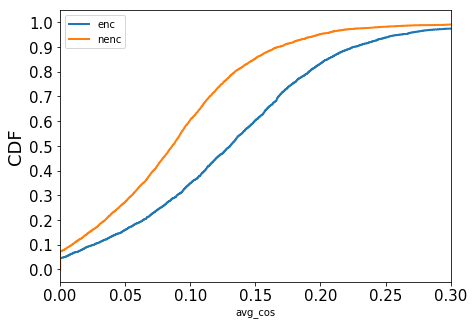

In [55]:
plotEncAndNencAvg(enc_df, not_enc_df, ["enc", "nenc"]);

806
1628


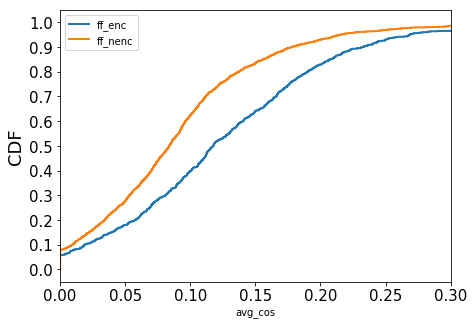

In [56]:
plotEncAndNencAvg(ff_enc, ff_nenc, ["ff_enc", "ff_nenc"])

798
1547


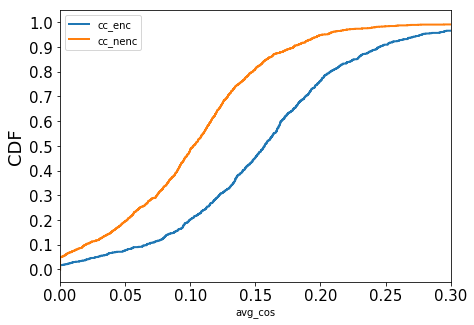

In [57]:
plotEncAndNencAvg(cc_enc, cc_nenc, ["cc_enc", "cc_nenc"])

982
1767


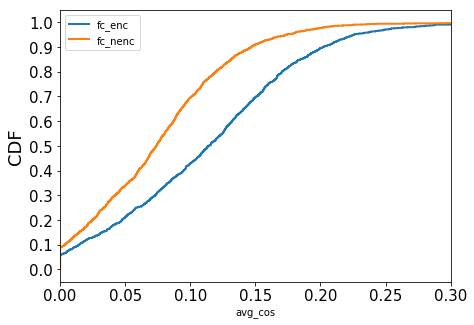

In [58]:
plotEncAndNencAvg(fc_enc, fc_nenc, ["fc_enc", "fc_nenc"])

In [59]:
def flatten(df, field):
    return list(itertools.chain.from_iterable(df[field]))

In [60]:
field = "cos_sims_list"
# Just keep all. --> No difference in getting significant results, either way p-value is <<< 0.05
FF = pd.Series(flatten(ff_enc, field))
CC = pd.Series(flatten(cc_enc, field))
FC = pd.Series(flatten(fc_enc, field))
NN = pd.Series(flatten(not_enc_df, field)) # NOT ENC GROUP.
# NN is big, subsample it.
NN = NN.sample(frac = 0.2, random_state = random_state)

In [61]:
print("FF vs *:")
print(st.mannwhitneyu(FF, CC).pvalue)
print(st.mannwhitneyu(FF, FC).pvalue)
print(st.mannwhitneyu(FF, NN).pvalue)

FF vs *:
7.529450882629639e-142
0.16441217041759243
1.273970846229618e-69


In [62]:
print("CC vs *:")
print(st.mannwhitneyu(CC, FF).pvalue)
print(st.mannwhitneyu(CC, FC).pvalue)
print(st.mannwhitneyu(CC, NN).pvalue)

CC vs *:
7.529450882628353e-142
6.105639031682373e-265
0.0


In [63]:
print("FC vs *:")
print(st.mannwhitneyu(FC, FF).pvalue)
print(st.mannwhitneyu(FC, CC).pvalue)
print(st.mannwhitneyu(FC, NN).pvalue)

FC vs *:
0.16441217041759237
6.105639031682373e-265
1.0640235180981945e-156


## Fig 2, Device Types:

In [64]:
upper = pd.concat([FF, CC, FC, NN]).quantile(q = 0.99)
print(upper)

0.395107091665268


1000
1000
1000
1000


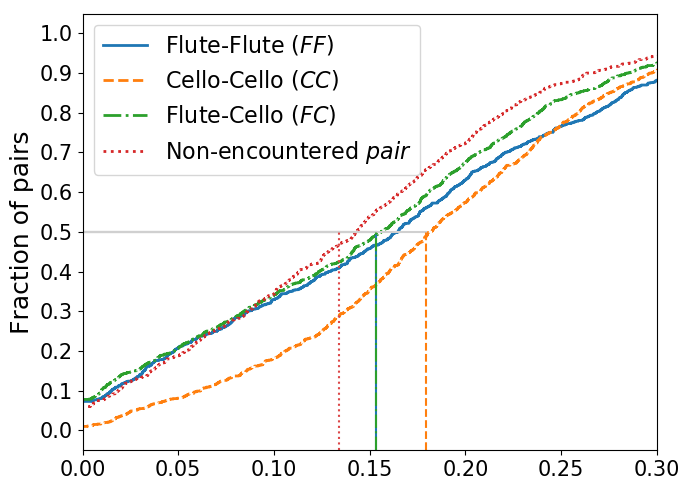

CPU times: user 953 ms, sys: 562 ms, total: 1.52 s
Wall time: 675 ms


In [65]:
%%time
# sns.set(font_scale=1.6)
# sns.set_style("white")
sns.reset_defaults()
sample_size = 1000
ax = cdf_plot(FF.sample(n = sample_size, random_state = random_state), lineStyle='-')
ax = cdf_plot(CC.sample(n = sample_size, random_state = random_state), ax = ax, lineStyle='--')
ax = cdf_plot(FC.sample(n = sample_size, random_state = random_state), ax = ax, lineStyle='-.')
ax = cdf_plot(NN.sample(n = sample_size, random_state = random_state), ax = ax, lineStyle=':', 
              ylabel = 'Fraction of pairs')
upper_xlim = 0.3;
ax.set_xlim([0, upper_xlim])
ax.legend(["Flute-Flute $(FF)$", "Cello-Cello $(CC)$", 
           'Flute-Cello $(FC)$', 'Non-encountered $pair$'], fontsize = 16)

# plt.axhspan(0.5, 0.51, facecolor='blue', alpha = 0.5)
# plt.axvspan(FF.quantile(q = 0.5), FF.quantile(q = 0.51), facecolor='gray', alpha = 0.5)
ymax = 0.5
# Color values come from inspection of values pandas plotting uses!
xmax = FF.quantile(q = ymax)
plt.axhline(y = ymax, color='#D0D0D0', xmin=0, lineStyle='-', xmax=xmax/upper_xlim) # set_xlim messes this up, have to scale...!
plt.axvline(x = xmax, color='#1f77b4', ymin=0, ymax=ymax, lineStyle='-')

xmax = CC.quantile(q = ymax)
plt.axhline(y = ymax, color='#D0D0D0', xmin=0, lineStyle='-', xmax=xmax/upper_xlim) # set_xlim messes this up, have to scale...!
plt.axvline(x = xmax, color='#ff7f0e', ymin=0, ymax=ymax, lineStyle='--')

xmax = FC.quantile(q = ymax)
plt.axhline(y = ymax, color='#D0D0D0', xmin=0, lineStyle='-', xmax=xmax/upper_xlim) # set_xlim messes this up, have to scale...!
plt.axvline(x = xmax, color='#2ca02c', ymin=0, ymax=ymax, lineStyle='-.')

xmax = NN.quantile(q = ymax)
plt.axhline(y = ymax, color='#D0D0D0', xmin=0, lineStyle='-', xmax=xmax/upper_xlim) # set_xlim messes this up, have to scale...!
plt.axvline(x = xmax, color='#dc4647', ymin=0, ymax=ymax, lineStyle=':')

ax.set_xlabel("Pairwise cosine similarity of traffic profiles", fontsize=18)
plt.tight_layout()
plt.savefig("Fig2_cdf_pairwise_devType_v501.pdf", dpi=160)
plt.show()

In [66]:
def getAngularSimFromCos(cos):
    return 1 - ( math.acos(cos - 2.2e-16) / math.pi );

2000
2000
2000
2000


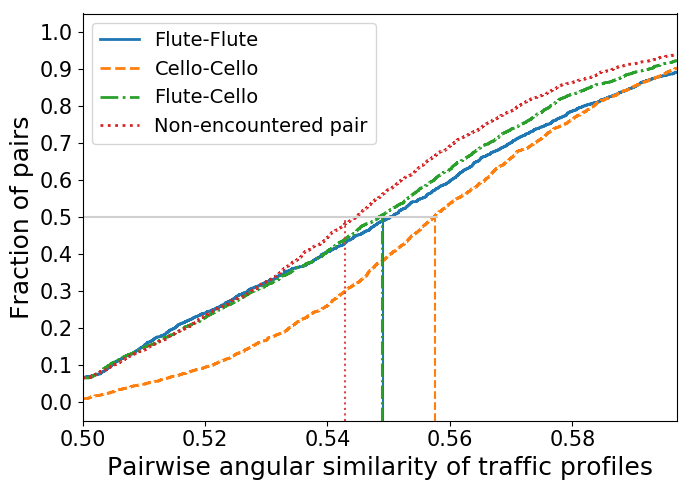

CPU times: user 438 ms, sys: 328 ms, total: 766 ms
Wall time: 346 ms


In [67]:
%%time
# Angular version of the above!
sns.reset_defaults()
sample_size = 2000
ax = cdf_plot(FF.sample(n = sample_size, random_state = random_state).apply(getAngularSimFromCos), lineStyle='-')
ax = cdf_plot(CC.sample(n = sample_size, random_state = random_state).apply(getAngularSimFromCos), ax = ax, lineStyle='--')
ax = cdf_plot(FC.sample(n = sample_size, random_state = random_state).apply(getAngularSimFromCos), ax = ax, lineStyle='-.')
ax = cdf_plot(NN.sample(n = sample_size, random_state = random_state).apply(getAngularSimFromCos), ax = ax, lineStyle=':', 
              ylabel = 'Fraction of pairs')
upper_xlim = getAngularSimFromCos(0.3);
ax.set_xlim([0.5, upper_xlim])
ax.legend(['Flute-Flute', 'Cello-Cello', 'Flute-Cello', 'Non-encountered pair'], prop={'size': 14})

# plt.axhspan(0.5, 0.51, facecolor='blue', alpha = 0.5)
# plt.axvspan(FF.quantile(q = 0.5), FF.quantile(q = 0.51), facecolor='gray', alpha = 0.5)
ymax = 0.5
# Color values come from inspection of values pandas plotting uses!
xmax = getAngularSimFromCos(FF.quantile(q = ymax))
plt.axvline(x = xmax, color='#1f77b4', ymin=0, ymax=ymax, lineStyle='-')

xmax = getAngularSimFromCos(CC.quantile(q = ymax))
plt.axvline(x = xmax, color='#ff7f0e', ymin=0, ymax=ymax, lineStyle='--')

xmax = getAngularSimFromCos(FC.quantile(q = ymax))
plt.axvline(x = xmax, color='#2ca02c', ymin=0, ymax=ymax, lineStyle='-.')

xmax = getAngularSimFromCos(NN.quantile(q = ymax))
plt.axhline(y = ymax, color='#D0D0D0', xmin=0, lineStyle='-', xmax=upper_xlim)
plt.axvline(x = xmax, color='#dc4647', ymin=0, ymax=ymax, lineStyle=':')

ax.set_xlabel("Pairwise angular similarity of traffic profiles", fontsize=18)
plt.tight_layout()
plt.show()

# Separate Weekdays and Weekends:

In [68]:
wd_enc = enc_df[enc_df['day'].isin(wd)]
wd_nenc = not_enc_df[not_enc_df['day'].isin(wd)]

we_enc = enc_df[enc_df['day'].isin(we)]
we_nenc = not_enc_df[not_enc_df['day'].isin(we)]

In [69]:
field = "cos_sims_list"

print("Weekday FF", len(pd.Series(flatten(wd_enc[wd_enc['devType']==0], field))))
print("Weekday CC", len(pd.Series(flatten(wd_enc[wd_enc['devType']==1], field))))
print("Weekday FC", len(pd.Series(flatten(wd_enc[wd_enc['devType']==2], field))))

print("Weekend FF", len(pd.Series(flatten(we_enc[we_enc['devType']==0], field))))
print("Weekend CC", len(pd.Series(flatten(we_enc[we_enc['devType']==1], field))))
print("Weekend FC", len(pd.Series(flatten(we_enc[we_enc['devType']==2], field))))

Weekday FF 12618
Weekday CC 21723
Weekday FC 30185
Weekend FF 1867
Weekend CC 3050
Weekend FC 4336


In [70]:
field = "cos_sims_list"
flat_wd_enc = pd.Series(flatten(wd_enc, field))
flat_wd_nenc = pd.Series(flatten(wd_nenc, field))
flat_we_enc = pd.Series(flatten(we_enc, field))
flat_we_nenc = pd.Series(flatten(we_nenc, field)) # NOT ENC GROUP.
# wd_nenc is big, subsample it.
flat_wd_nenc = flat_wd_nenc.sample(frac = 0.05, random_state = random_state)

In [71]:
np.median(flat_wd_enc)

0.1593300849199295

In [72]:
np.median(flat_wd_nenc)

0.12324216589331627

In [73]:
np.median(flat_we_enc)

0.18898020684719086

In [74]:
np.median(flat_we_nenc)

0.16684254258871078

In [75]:
len(flat_wd_nenc)

59490

In [76]:
print("flat_wd_enc vs *:")
print(st.mannwhitneyu(flat_wd_enc, flat_wd_nenc).pvalue)
print(st.mannwhitneyu(flat_wd_enc, flat_we_enc).pvalue)
print(st.mannwhitneyu(flat_wd_enc, flat_we_nenc).pvalue)

flat_wd_enc vs *:
0.0
1.955305468886584e-132
1.2560116376267404e-38


In [77]:
print("flat_wd_nenc vs *:")
print(st.mannwhitneyu(flat_wd_nenc, flat_wd_enc).pvalue)
print(st.mannwhitneyu(flat_wd_nenc, flat_we_enc).pvalue)
print(st.mannwhitneyu(flat_wd_nenc, flat_we_nenc).pvalue)

flat_wd_nenc vs *:
0.0
0.0
0.0


In [78]:
print("flat_we_enc vs *:")
print(st.mannwhitneyu(flat_we_enc, flat_wd_enc).pvalue)
print(st.mannwhitneyu(flat_we_enc, flat_wd_nenc).pvalue)
print(st.mannwhitneyu(flat_we_enc, flat_we_nenc).pvalue)

flat_we_enc vs *:
1.955305468886584e-132
0.0
5.783991097339134e-90


## Fig 3, Weekday vs Weekend:

2000
2000
2000
2000


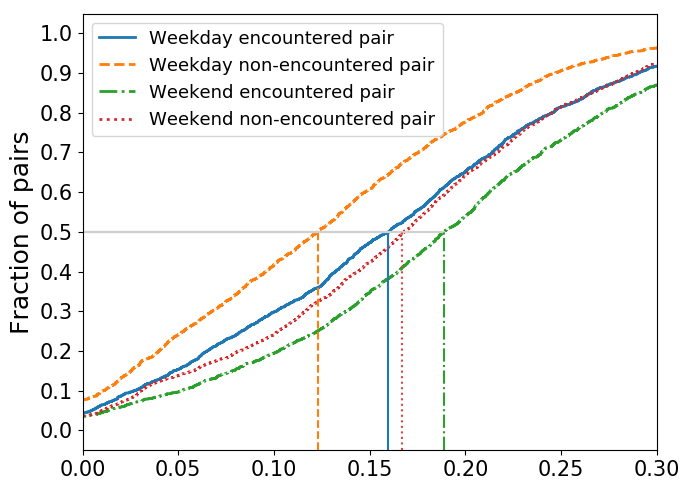

CPU times: user 875 ms, sys: 406 ms, total: 1.28 s
Wall time: 541 ms


In [79]:
%%time
sample_size = 2000
ax = cdf_plot(flat_wd_enc.sample(n = sample_size, random_state = random_state), lineStyle='-')
ax = cdf_plot(flat_wd_nenc.sample(n = sample_size, random_state = random_state), ax = ax, lineStyle='--')
ax = cdf_plot(flat_we_enc.sample(n = sample_size, random_state = random_state), ax = ax, lineStyle='-.')
ax = cdf_plot(flat_we_nenc.sample(n = sample_size, random_state = random_state), ax = ax, lineStyle=':', 
              ylabel = 'Fraction of pairs')
upper_xlim = 0.3;
ax.set_xlim([0, upper_xlim])
ax.legend(['Weekday encountered pair', 'Weekday non-encountered pair', 
           'Weekend encountered pair', 'Weekend non-encountered pair'], prop={'size': 13})

# plt.axhspan(0.5, 0.51, facecolor='blue', alpha = 0.5)
# plt.axvspan(FF.quantile(q = 0.5), FF.quantile(q = 0.51), facecolor='gray', alpha = 0.5)
ymax = 0.5
# Color values come from inspection of values pandas plotting uses!
xmax = flat_wd_enc.quantile(q = ymax)
plt.axhline(y = ymax, color='#D0D0D0', xmin=0, lineStyle='-', xmax=xmax/upper_xlim) # set_xlim messes this up, have to scale...!
plt.axvline(x = xmax, color='#1f77b4', ymin=0, ymax=ymax, lineStyle='-')

xmax = flat_wd_nenc.quantile(q = ymax)
plt.axhline(y = ymax, color='#D0D0D0', xmin=0, lineStyle='-', xmax=xmax/upper_xlim) # set_xlim messes this up, have to scale...!
plt.axvline(x = xmax, color='#ff7f0e', ymin=0, ymax=ymax, lineStyle='--')

xmax = flat_we_enc.quantile(q = ymax)
plt.axhline(y = ymax, color='#D0D0D0', xmin=0, lineStyle='-', xmax=xmax/upper_xlim) # set_xlim messes this up, have to scale...!
plt.axvline(x = xmax, color='#2ca02c', ymin=0, ymax=ymax, lineStyle='-.')

xmax = flat_we_nenc.quantile(q = ymax)
plt.axhline(y = ymax, color='#D0D0D0', xmin=0, lineStyle='-', xmax=xmax/upper_xlim) # set_xlim messes this up, have to scale...!
plt.axvline(x = xmax, color='#dc4647', ymin=0, ymax=ymax, lineStyle=':')

ax.set_xlabel("Pairwise cosine similarity of traffic profiles", fontsize=18)
plt.tight_layout()
plt.savefig("Fig3_cdf_pairwise_wdwe_v501.pdf", dpi=160)
plt.show()

# Separate Encounter durations

Re-populate the encountered pairs' stats, this time create encounter duration buckets.  
Non-encountered pairs' stats does not need updating, since not_enc group doesn't have duration category.

In [85]:
encountered = {}  # u1, u2, day, bldg.
# HashMap for Encountered pairs' stats.
enc_cos = defaultdict(list)

# Populate encounter pairs' stats.
for f in tqdm_notebook(encounter_files):
    gc.collect()
    ### INPUT:
    enc = pd.read_parquet(f, engine="pyarrow")
    # Take the filename only, remove '.br.parquet'.
    bldg = int(f.split("/")[-1][:-11])
    ### PROCESSING:
    # devType counters
    ff = 0
    cc = 0
    fc = 0
    aa = 0
    # Duration counters
    short = 0
    med = 0
    long = 0
    # Get cosine sim stats for encountered pairs.
    for row in zip(
        enc["uid1"],
        enc["uid2"],
        enc["day"],
        enc["uid1_device"],
        enc["uid2_device"],
        enc["dur"],
    ):
        # Unpack the row for readability.
        uid1 = row[0]
        uid2 = row[1]
        day = row[2]
        dev1 = row[3]
        dev2 = row[4]
        dur = row[5]
        # An encounter between u1,u2 in this day and building has already been counted, skip it.
        memo_key = str(uid1) + "#" + str(uid2) + "#" + str(day) + "#" + str(bldg)
        if memo_key in encountered:
            continue

        # Determine device types, devType is a number from 0 to 3.
        if dev1 == "f" and dev2 == "f":  # (flute, flute) case.
            devType = 0
            ff += 1
        elif dev1 == "c" and dev2 == "c":  # (cellos, cellos) case.
            devType = 1
            cc += 1
        elif (dev1 == "f" and dev2 == "c") or (
            dev1 == "c" and dev2 == "f"
        ):  # (f, c) or (c, f)
            devType = 2
            fc += 1
        else:  # One or both devices are neither in cellos nor flutes (any, any), shouldn't happen in sample.
            devType = 3
            aa += 1
        
        # Determine duration category, the cut-offs are based on separate analysis of encounter durations.
        if dur < 38:
            durCat = 0; # Short encounter.
            short += 1;
        elif dur >= 38 and dur < 317:
            durCat = 1; # Medium encounter.
            med += 1;
        elif dur >= 317:
            durCat = 2; # Long encounter.
            long += 1; 

        tuple1 = (uid1, bldg, day)
        tuple2 = (uid2, bldg, day)
        if tuple1 in key2index and tuple2 in key2index:
            u1 = tfidf[key2index[tuple1],]
            u2 = tfidf[key2index[tuple2],]

            enc_cos[(bldg, day, devType, durCat)].append(getCosineSim(u1, u2))
            encountered[memo_key] = True

In [91]:
keys_name = [key[0] for key in enc_cos.keys()]
keys_day = [key[1] for key in enc_cos.keys()]
keys_devType = [key[2] for key in enc_cos.keys()]
keys_durCat = [key[3] for key in enc_cos.keys()]
vals = [val for val in enc_cos.values()]
enc_df = pd.DataFrame(
    {
        "name": keys_name,
        "day": keys_day,
        "devType": keys_devType,
        "durCat": keys_durCat,
        "cos_sims_list": vals,
    }
)

enc_df['avg_cos'] = enc_df.cos_sims_list.apply(getAverageOfList)
enc_df['med_cos'] = enc_df.cos_sims_list.apply(np.median)

enc_df.head()

,name,day,devType,durCat,cos_sims_list,avg_cos,med_cos
0,1,11,1,2,[0.014423125],0.014423,0.014423
1,1,24,1,2,[0.08345036],0.083450,0.083450
2,1,10,1,1,[0.0],0.000000,0.000000
3,1,19,1,1,[0.054598715],0.054599,0.054599
4,1,23,1,2,[0.22902693],0.229027,0.229027


In [92]:
not_enc_df.head()

,name,day,devType,cos_sims_list,avg_cos,med_cos
0,1,6,1,[0.0],0.000000,0.000000
1,1,6,2,"[0.020571439, 0.020069953, 0.0, 0.0]",0.010160,0.010035
2,1,6,0,[0.18170688],0.181707,0.181707
3,1,7,0,[0.0],0.000000,0.000000
4,1,9,1,"[0.1277339, 0.018610274]",0.073172,0.073172


###### Separate the different duration categories:

In [93]:
s_enc = enc_df[enc_df.durCat==0]
m_enc = enc_df[enc_df.durCat==1]
l_enc = enc_df[enc_df.durCat==2]

In [94]:
print("short, medium, long counts:")
print(len(s_enc), len(m_enc), len(l_enc), sep=",")

short, medium, long counts:
1225,1506,2316


Let's plot the averages:

1225
1506
2316
4942


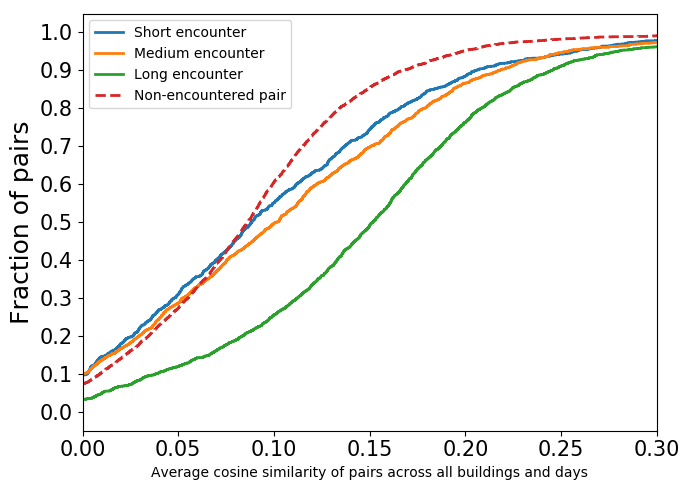

In [95]:
ax = cdf_plot(s_enc.avg_cos)
ax = cdf_plot(m_enc.avg_cos, ax = ax)
ax = cdf_plot(l_enc.avg_cos, ax = ax)
ax = cdf_plot(not_enc_df.avg_cos, ax = ax, lineStyle='--', ylabel = 'Fraction of pairs')
ax.set_xlim([0, 0.3])
ax.set_xlabel("Average cosine similarity of pairs across all buildings and days")
ax.legend(["Short encounter", "Medium encounter", "Long encounter", "Non-encountered pair"])
plt.tight_layout()
plt.show()

One could also look at individual buildings:

44
46
54
75


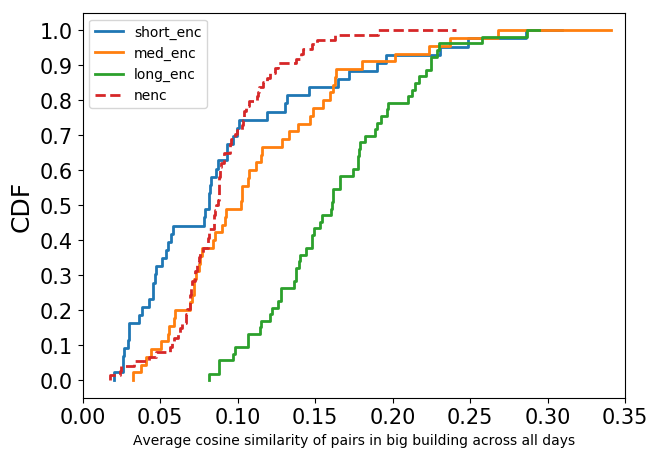

In [99]:
ax = cdf_plot(s_enc[s_enc.name==17].avg_cos)
ax = cdf_plot(m_enc[m_enc.name==17].avg_cos, ax = ax)
ax = cdf_plot(l_enc[l_enc.name==17].avg_cos, ax = ax)
ax = cdf_plot(not_enc_df[not_enc_df.name==17].avg_cos, ax = ax, lineStyle='--')
ax.set_xlim([0, 0.35])
ax.set_xlabel("Average cosine similarity of pairs in a big building across all days")
ax.legend(["short_enc", "med_enc", "long_enc", "nenc"])
plt.show()

Flatten the list of similarities and analyze them:

In [146]:
# Define groups of encounter duration.
N = 5000
short = pd.Series(flatten(s_enc, 'cos_sims_list')).sample(n = N, random_state = random_state)
medium = pd.Series(flatten(m_enc, 'cos_sims_list')).sample(n = N, random_state = random_state)
long = pd.Series(flatten(l_enc, 'cos_sims_list')).sample(n = N, random_state = random_state)
nenc = pd.Series(flatten(not_enc_df, 'cos_sims_list')).sample(n = N, random_state = random_state)

In [147]:
print("short vs *:")
print(st.mannwhitneyu(short, medium).pvalue)
print(st.mannwhitneyu(short, long).pvalue)
print(st.mannwhitneyu(short, nenc).pvalue)

short vs *:
3.2829838632646615e-06
3.5018486390819595e-97
0.01244700706734648


In [148]:
print("medium vs *:")
print(st.mannwhitneyu(medium, short).pvalue)
print(st.mannwhitneyu(medium, long).pvalue)
print(st.mannwhitneyu(medium, nenc).pvalue)

medium vs *:
3.2829838632646615e-06
7.407887955541792e-60
0.006902920728880029


In [149]:
print("long vs *:")
print(st.mannwhitneyu(long, short).pvalue)
print(st.mannwhitneyu(long, medium).pvalue)
print(st.mannwhitneyu(long, nenc).pvalue)

long vs *:
3.5018486390819595e-97
7.407887955541792e-60
8.216733890539921e-85


## Fig 4, Encounter Duration:

5000
5000
5000
5000


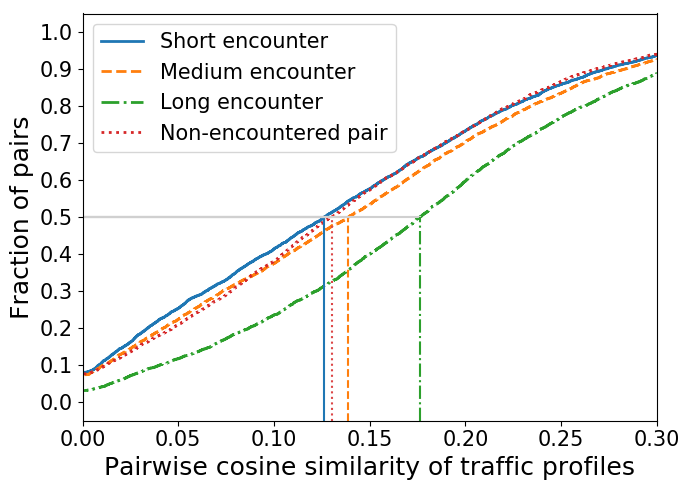

CPU times: user 1 s, sys: 438 ms, total: 1.44 s
Wall time: 646 ms


In [152]:
%%time
ax = cdf_plot(short, lineStyle="-")
ax = cdf_plot(medium, ax=ax, lineStyle="--")
ax = cdf_plot(long, ax=ax, lineStyle="-.")
ax = cdf_plot(nenc, ax=ax, lineStyle=":", ylabel="Fraction of pairs")
upper_xlim = 0.3
ax.set_xlim([0, upper_xlim])
ax.legend(
    ["Short encounter", "Medium encounter", "Long encounter", "Non-encountered pair"],
    fontsize=15,
)

# plt.axhspan(0.5, 0.51, facecolor='blue', alpha = 0.5)
# plt.axvspan(FF.quantile(q = 0.5), FF.quantile(q = 0.51), facecolor='gray', alpha = 0.5)
ymax = 0.5
# Color values come from inspection of values pandas plotting uses!
xmax = short.quantile(q=ymax)
plt.axhline(
    y=ymax, color="#D0D0D0", xmin=0, lineStyle="-", xmax=xmax / upper_xlim
)  # set_xlim messes this up, have to scale...!
plt.axvline(x=xmax, color="#1f77b4", ymin=0, ymax=ymax, lineStyle="-")

xmax = medium.quantile(q=ymax)
plt.axhline(
    y=ymax, color="#D0D0D0", xmin=0, lineStyle="-", xmax=xmax / upper_xlim
)  # set_xlim messes this up, have to scale...!
plt.axvline(x=xmax, color="#ff7f0e", ymin=0, ymax=ymax, lineStyle="--")

xmax = long.quantile(q=ymax)
plt.axhline(
    y=ymax, color="#D0D0D0", xmin=0, lineStyle="-", xmax=xmax / upper_xlim
)  # set_xlim messes this up, have to scale...!
plt.axvline(x=xmax, color="#2ca02c", ymin=0, ymax=ymax, lineStyle="-.")

xmax = nenc.quantile(q=ymax)
plt.axhline(
    y=ymax, color="#D0D0D0", xmin=0, lineStyle="-", xmax=xmax / upper_xlim
)  # set_xlim messes this up, have to scale...!
plt.axvline(x=xmax, color="#dc4647", ymin=0, ymax=ymax, lineStyle=":")

ax.set_xlabel("Pairwise cosine similarity of traffic profiles", fontsize=18)
plt.tight_layout()
plt.savefig("Fig4_cdf_pairwise_encDurCat_v601.pdf", dpi=160)
plt.show()


###### Mannwhitney U test of short_enc/med_enc/long_enc vs nenc on same (bldg, day):

In [153]:
bldgs = sorted( set(enc_df.name).intersection(set(not_enc_df.name)) )
days = sorted( set(enc_df.day).intersection(set(not_enc_df.day)) )

In [155]:
not_enough_samples = [0, 0, 0, 0] # short, med, long, nenc.
total = len(bldgs) * len(days)

mann_bldgs = []
mann_days = []
mann_durCat = [] # 0, 1, 2 for short, med, long.
# pval of comparison vs nenc.
mann_pval = []

for bldg in tqdm_notebook(bldgs):
    for day in days:
        short = list(itertools.chain.from_iterable(s_enc[( (s_enc.name==bldg) & (s_enc.day==day) )]['cos_sims_list']))
        med   = list(itertools.chain.from_iterable(m_enc[( (m_enc.name==bldg) & (m_enc.day==day) )]['cos_sims_list']))
        long  = list(itertools.chain.from_iterable(l_enc[( (l_enc.name==bldg) & (l_enc.day==day) )]['cos_sims_list']))
        nenc  = list(itertools.chain.from_iterable(not_enc_df[( (not_enc_df.name==bldg) & (not_enc_df.day==day) )]['cos_sims_list']))
    
        if (len(nenc) < n_min_count):
            not_enough_samples[3] += 1;
            continue;
        #
        if (len(short) < n_min_count):
            not_enough_samples[0] += 1
        else:            
            mann_bldgs.append(bldg)
            mann_days.append(day)
            mann_durCat.append(0)
            t, p = st.mannwhitneyu(short, nenc)
            mann_pval.append(p)
        #    
        if (len(med) < n_min_count):
            not_enough_samples[1] += 1
        else:
            mann_bldgs.append(bldg)
            mann_days.append(day)
            mann_durCat.append(1)
            t, p = st.mannwhitneyu(med, nenc)
            mann_pval.append(p)
        #     
        if (len(long) < n_min_count):
            not_enough_samples[2] += 1
        else:
            mann_bldgs.append(bldg)
            mann_days.append(day)
            mann_durCat.append(2)
            t, p = st.mannwhitneyu(long, nenc)
            mann_pval.append(p)

print("total, short, med, long, nenc not enough samples : ")
print(total, not_enough_samples, sep=",")
print("in % of total with not enough samples: ")
print(np.array(not_enough_samples)/total*100)


total, short, med, long, nenc not enough samples : 
1862,[840, 807, 645, 940]
in % of total with not enough samples: 
[45.11278195 43.34049409 34.64017186 50.48335124]


In [157]:
comparison_df = pd.DataFrame(
    {"bldg": mann_bldgs, "day": mann_days, "durCat": mann_durCat, "pval": mann_pval}
)

In [158]:
total = len(comparison_df)

In [165]:
significance_level = 0.05

In [166]:
print(
    "%Significant pval of all (bldg, day, durCat):",
    len(comparison_df[comparison_df.pval < significance_level]) / total * 100,
    "%",
)

%Significant pval of all (bldg, day, durCat): 66.45569620253164 %


In [167]:
tmp = comparison_df[comparison_df.durCat==0]
print("%Significant pval of all (bldg, day, durCat==0 or short) tuples:",
      len(tmp[tmp.pval < significance_level])/len(tmp)*100,"%")

%Significant pval of all (bldg, day, durCat==0 or short): 35.36585365853659 %


In [168]:
tmp = comparison_df[comparison_df.durCat==1]
print("%Significant pval of all (bldg, day, durCat==1 or med) tuples:",
      len(tmp[tmp.pval < significance_level])/len(tmp)*100,"%")

%Significant pval of all (bldg, day, durCat==1 or med): 45.21739130434783 %


In [169]:
tmp = comparison_df[comparison_df.durCat==2]
print("%Significant pval of all (bldg, day, durCat==2 or long) tuples:",
      len(tmp[tmp.pval < significance_level])/len(tmp)*100,"%")

%Significant pval of all (bldg, day, durCat==2 or long): 84.47653429602889 %
